In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

plt.style.use("~/profile/python/plotting/style.mplstyle")
plt.style.use("dark_background")
np.random.seed(342309823)

# Least Squares

In [2]:
def f(x, alpha, beta):
    return x * alpha + beta

def sse(params, x, y):
    alpha, beta = params
    ypred = f(x, alpha, beta)
    
    residual = y - ypred
    return np.sum(residual**2)

alpha_true, beta_true = 1, 0

# Observed data
SIZE = 100
xdata = np.random.uniform(size=SIZE)
yscatter = np.random.normal(scale=0.1, size=SIZE)
ytrue = f(xdata, alpha_true, beta_true)
ydata = ytrue + yscatter

In [3]:
from scipy.optimize import minimize

result = minimize(sse, x0=[0, 0], args=(xdata, ydata))
alpha_best, beta_best = result.x

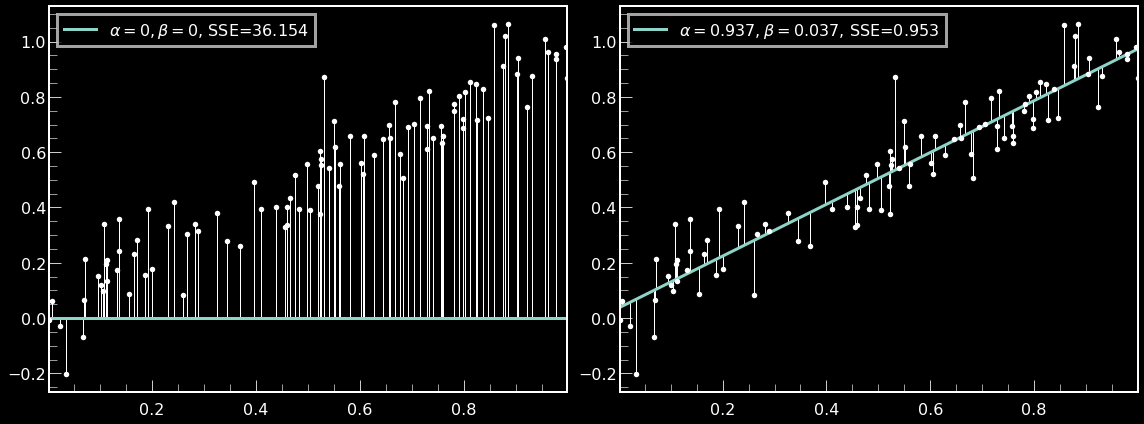

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot guess
ax = axs[0]
alpha, beta = 0, 0
xrange = np.linspace(min(xdata), max(xdata), 1000)
ax.plot(xrange, f(xrange, alpha, beta), label=fr"$\alpha={alpha}, \beta={beta}$, SSE=${sse((alpha, beta), xdata, ydata):.3f}$")

ax.scatter(xdata, ydata, s=30, lw=0, zorder=100, color='w');
ax.vlines(xdata, ydata, f(xdata, alpha, beta), lw=1, color='w')
ax.legend()

# Plot fit
ax = axs[1]
alpha, beta = alpha_best, beta_best
xrange = np.linspace(min(xdata), max(xdata), 1000)
ax.plot(xrange, f(xrange, alpha, beta), label=fr"$\alpha={alpha:.3f}, \beta={beta:.3f}$, SSE=${sse((alpha, beta), xdata, ydata):.3f}$")

ax.scatter(xdata, ydata, s=30, lw=0, zorder=100, color='w');
ax.vlines(xdata, ydata, f(xdata, alpha, beta), lw=1, color='w')
ax.legend()

plt.tight_layout();
plt.savefig("figures/least_squares.pdf");

# Chi-Square

## Example: Microlensing

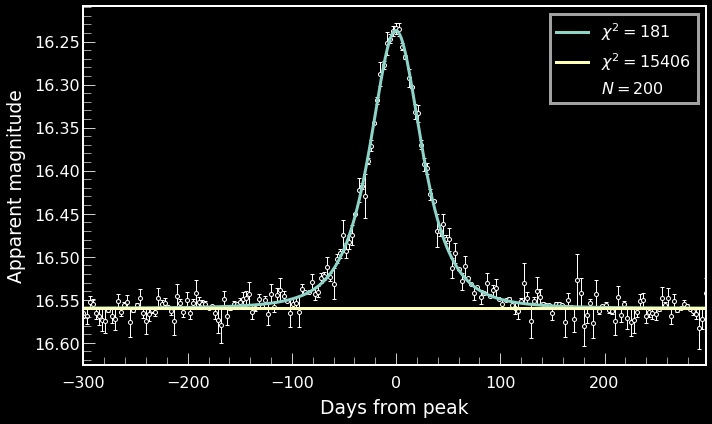

In [5]:
import MulensModel as mm

def f(A, f_source=150, f_blend=0):
    return mm.Utils.get_mag_from_flux(A * f_source + f_blend)

def sse(params, x, y):
    t_0, u_0, t_E = params
    model = mm.Model({"t_0": t_0, "u_0": u_0, "t_E": t_E})
    ypred = f(model.magnification(x))
    
    residual = y - ypred
    return np.sum(residual**2)

def chi2(params, x, y, ysigma):
    t_0, u_0, t_E = params
    model = mm.Model({"t_0": t_0, "u_0": u_0, "t_E": t_E})
    ypred = f(model.magnification(x))
    
    residual_over_sigma = (y - ypred) / ysigma
    return np.sum(residual_over_sigma**2)

# Plot observed
plt.figure(figsize=(10, 6))
model = mm.Model({
    "t_0": 0,
    "u_0": 1,
    "t_E": 30,
})
xdata = np.arange(-300, 300, 3)
ytrue = f(model.magnification(xdata))
ystat = np.log(10) * 10**(-0.4*(ytrue-mm.utils.MAG_ZEROPOINT)*-3/2)
ysys = 0.01
ysigma = np.sqrt(ystat**2 + ysys**2)
yscatter = st.norm(scale=ysigma).rvs(len(ytrue))
ydata = ytrue + yscatter
plt.errorbar(xdata, ydata, yscatter, fmt=".", color="white", ecolor="white", elinewidth=1, mfc="black", zorder=-1)

# Plot least squares fit
# xrange = np.linspace(xdata.min(), xdata.max(), 1000)
# result = minimize(sse, x0=(0, 1, 50), args=(xdata, ydata))
# print(result.x)
# sse_value = sse(result.x, xdata, ydata)
# model = mm.Model({k: v for k, v in zip(["t_0", "u_0", "t_E"], result.x)})
# plt.plot(xrange, f(model.magnification(xrange)), lw=3, label=fr"SSE$= {sse_value:.2g}$, MSE$={sse_value/len(xdata):.2g}$")

# Plot chi2 fit
xrange = np.linspace(xdata.min(), xdata.max(), 1000)
result = minimize(chi2, x0=(0, 1, 50), args=(xdata, ydata, ysigma))
chi2_value = chi2(result.x, xdata, ydata, ysigma)
sse_value = sse(result.x, xdata, ydata)
model = mm.Model({k: v for k, v in zip(["t_0", "u_0", "t_E"], result.x)})
plt.plot(xrange, f(model.magnification(xrange)), lw=3, label=fr"$\chi^2 = {chi2_value:.0f}$")

# Plot null model
chi2_value = np.sum(((ydata - f(np.ones(shape=xdata.shape))) / ysigma)**2)
mse_value = np.mean((ydata - f(np.ones(shape=xdata.shape)))**2)
plt.plot(xrange, f(np.ones(shape=xrange.shape)), lw=3, label=fr"$\chi^2 = {chi2_value:.0f}$")

# Dummy plot for legend
plt.plot([], [], label=f"$N={len(xdata)}$", color='black')


plt.xlabel("Days from peak")
plt.ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.savefig("figures/microlensing.pdf");

# Maximum Likelihood

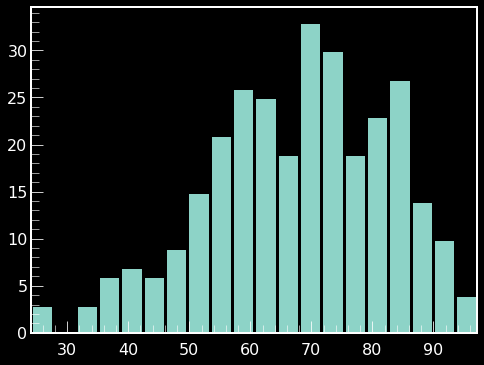

In [6]:
np.random.seed(3)
plt.hist(st.beta(a=6, b=3).rvs(300) * 100, edgecolor="k");

# Extra

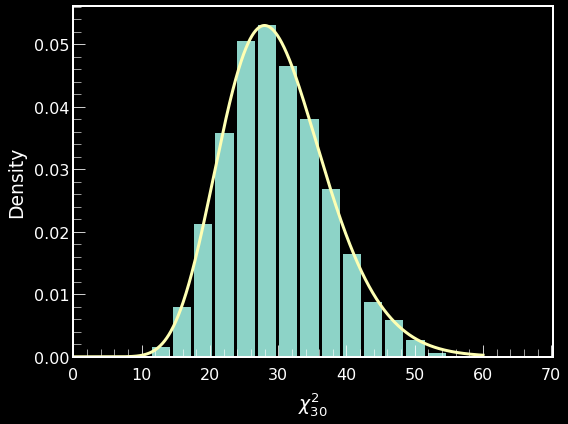

In [7]:
def chi2(size, sigma):
    epsilon = st.norm.rvs(scale=sigma, size=size)
    return np.sum(epsilon**2 / sigma**2)

sample_size = 30
nsamples = 10000
chi2_results = []
for i in range(nsamples):
    chi2_results.append(chi2(sample_size, 1))

plt.hist(chi2_results, edgecolor="black", density=True)

# Plot chi2 theoretical
xrange = np.linspace(0, 2*sample_size, 1000)
plt.plot(xrange, st.chi2(sample_size).pdf(xrange))

plt.xlabel(f"$\chi^2_{{{sample_size}}}$");
plt.ylabel("Density")

plt.tight_layout()
plt.savefig("figures/chi2_gaussian.pdf");